In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import tifffile
import numpy as np
from ipywidgets import widgets, interact
import matplotlib.pyplot as plt
%matplotlib inline  
from skimage import exposure
import skimage
import osDB
import pandas as pd
import os
import scipy
import scipy.ndimage
import skimage.morphology
import matplotlib.colors as colors

/media/daniel/Windows/Users/dnabu/Desktop/ResearchYogaWindows/DataJ/Programming/Python/Modules/tifffile.py:265: UserWarning: failed to import the optional _tifffile C extension module.
Loading of some compressed images will be very slow.
Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "failed to import the optional _tifffile C extension module.\n"


(1024, 1024)


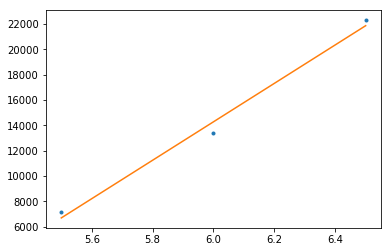

In [79]:
## get PH data
pH55 = r"/media/daniel/Windows/Users/dnabu/Desktop/ResearchYogaWindows/Miyoshi/8List/pH/pH55.tif"
pH60 = r"/media/daniel/Windows/Users/dnabu/Desktop/ResearchYogaWindows/Miyoshi/8List/pH/pH60.tif"
pH65 = r"/media/daniel/Windows/Users/dnabu/Desktop/ResearchYogaWindows/Miyoshi/8List/pH/pH65.tif"

#get image data
#create a pandas dataframe to hold data
index = ['pH55', 'pH60', 'pH65']
pHframe = pd.DataFrame(index=index)
pHframe['Files'] = ''
for row in index:
    pHframe['Files'].loc[row] = eval(row)

#get image data
pHframe['Image']=''
for row in pHframe.index:
    pHframe['Image'].loc[row] = tifffile.imread(pHframe['Files'].loc[row])
    
#shape?
print(pHframe['Image'].iloc[0].shape)

#get the mean inensity for each rgb channel
pHframe['Mean_intensity'] = ''
rgb = [0, 1, 2]
for row in pHframe.index:
    mean1 = []
    for c in rgb:
        mean1.append(np.mean(pHframe['Image'].loc[row]))
    pHframe['Mean_intensity'].loc[row] = mean1
    
#get green channel
pHframe['Mean_intensity'] = ''
rgb = [0, 1, 2]
for row in pHframe.index:
    pHframe['Mean_intensity'].loc[row] = np.mean(pHframe['Image'].loc[row])

pHframe['pH'] = [5.5, 6.0, 6.5]
plt.plot(pHframe['pH'].values, pHframe['Mean_intensity'].values, '.')
par= np.polyfit(pHframe['pH'].values, pHframe['Mean_intensity'].values, 1, full=True)
slope = par[0][0]
intercept=par[0][1]
xl = [min(pHframe['pH'].values), max(pHframe['pH'].values)]
yl = [slope*xx + intercept  for xx in xl]

plt.plot(xl, yl)
savefile = r'/media/daniel/Windows/Users/dnabu/Desktop/ResearchYogaWindows/Miyoshi/7List/Fig2/RegressionPlot.svg'
plt.savefig(savefile)

In [3]:
#find min and max in images
for row in pHframe.index:
    print(np.min(pHframe['Image'].loc[row]), np.max(pHframe['Image'].loc[row]))

6 255
6 255
6 255


In [4]:
def normalizeImage(img):    
    img = img - np.min(img)
    return img / np.max(img)

#determines the range
def setrange(x, xrange, limits):
    #x = number in index
    #range = the + and - of the given index
    #limits = [xin xmax] in possible range
    if x-xrange < limits[0]:
        x1 = limits[0]
    else:
        x1 = x-xrange
    if x + xrange > limits[1]:
        x2 = limits[1]
    else:
        x2 = x +xrange
    return np.arange(x1, x2)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [5]:
#find tif files to analyse
targetfolder = r'/media/daniel/Windows/Users/dnabu/Desktop/ResearchYogaWindows/Miyoshi/8List/Unbuffered'
files, index = osDB.getFileContString(targetfolder, '.tif')
#create pandas data frame for each file and generate full path
data = pd.DataFrame(index = files.values, columns=['pathfile', 'Image'])
for row in data.index:
    data['pathfile'].loc[row] = os.path.join(targetfolder, row)
    data['Image'].loc[row] = tifffile.imread(data['pathfile'].loc[row])
    
data

,pathfile,Image
11pHeffectFITC.tif,/media/daniel/Windows/Users/dnabu/Desktop/Rese...,"[[5935, 6092, 5851, 5815, 5964, 5869, 5824, 60..."
17unbuffered.tif,/media/daniel/Windows/Users/dnabu/Desktop/Rese...,"[[4812, 4648, 4662, 4651, 4555, 4745, 4672, 46..."
21unbuffered.tif,/media/daniel/Windows/Users/dnabu/Desktop/Rese...,"[[4397, 4346, 4371, 4495, 4490, 4375, 4318, 40..."
7FITC488.tif,/media/daniel/Windows/Users/dnabu/Desktop/Rese...,"[[5595, 5604, 5541, 5603, 5769, 5790, 5862, 58..."


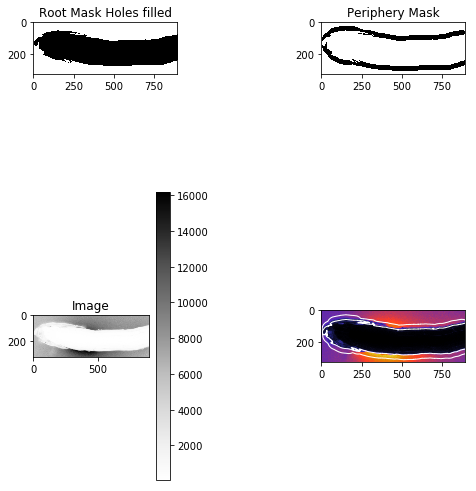

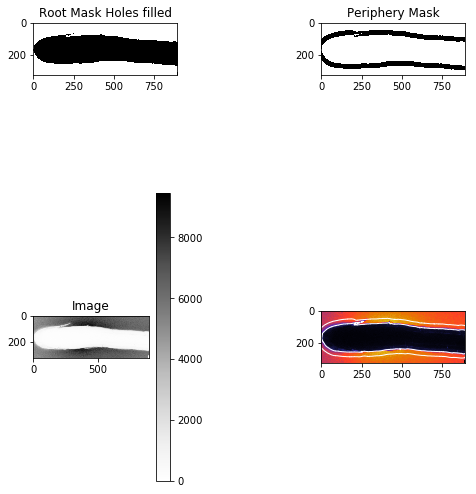

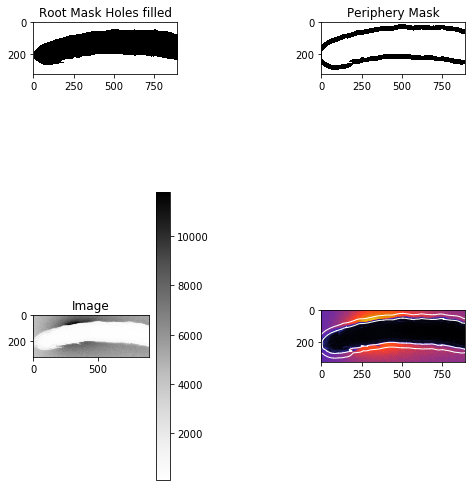

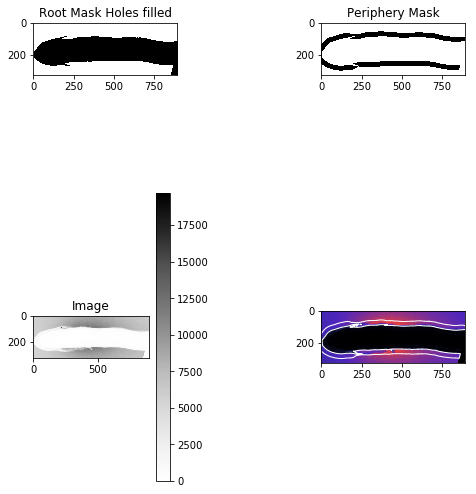

In [6]:

#create mask of image
data['Mask']=''
cmap = plt.get_cmap('CMRmap')
new_cmap = truncate_colormap(cmap, 0, 0.8)
outputfolder = r'/media/daniel/Windows/Users/dnabu/Desktop/ResearchYogaWindows/Miyoshi/8List/Figures'
for row in data.index:

    img = data['Image'].loc[row]
    fig1 =plt.figure(figsize=[10,10])
    ax1 = fig1.add_axes([0.1,0.1,0.2,0.4])
    img1 = ax1.imshow(img, cmap = 'Greys')
    fig1.colorbar(img1)
    ax1.set_title('Image')
    #create a mask of root only
    #then create mask of target region around the root through morphological filter

    reverse_index = np.where(img.flatten() <2500)
    imgmask = np.zeros(img.flatten().shape, dtype=np.bool)
    imgmask[reverse_index] = 1
    imgmask = imgmask.reshape(img.shape)
    imgmask2 = scipy.ndimage.binary_fill_holes(imgmask)
    ax2 = fig1.add_axes([0.1, 0.5, 0.2, 0.4])
    ax2.imshow(imgmask2, cmap='Greys')
    ax2.set_title('Root Mask Holes filled')

    #remove single points
    struct = skimage.morphology.disk(20, dtype = np.bool)
    imgmask3 = skimage.morphology.binary_erosion(imgmask2, struct)

    #dilate imgmask2 and create target mask
    #struct = scipy.ndimage.generate_binary_structure(5,5).astype(imgmask.dtype)
    struct = skimage.morphology.disk(50, dtype = np.bool)
    imgmask4 = skimage.morphology.binary_dilation(imgmask3, struct)
    indexTrue = np.where(imgmask2.flatten())
    indexTrueDilated = np.where(imgmask4.flatten())
    indexUnique = np.setdiff1d(indexTrueDilated, indexTrue)
    mask5 = np.zeros(img.flatten().shape, dtype = np.bool)
    mask5[indexUnique] = 1
    mask5 = mask5.reshape(img.shape)
    data['Mask'].loc[row] = indexUnique
    ax3 = fig1.add_axes([0.5, 0.5, 0.2, 0.4])
    ax3.imshow(mask5, cmap='Greys')
    ax3.set_title('Periphery Mask')
    ax4=fig1.add_axes([0.5, 0.1, 0.2, 0.4])
    ax4.imshow(img, cmap=new_cmap)
    contours = skimage.measure.find_contours(mask5, 0.8)
    for n, contour in enumerate(contours):
        ax4.plot(contour[:, 1], contour[:, 0], linewidth = 1, color = 'w')



    fig1.savefig(os.path.join(outputfolder, row[:-3] + 'jpeg'), dpi = 300)

In [7]:
#get data using mask from each image
#intensity data taken along root
xrange = 11 #range/window along x-axis
data["Intensity_values"] = ''
for row in data.index:
    img = data['Image'].loc[row]
    maskIndex = data['Mask'].loc[row]
    mask = np.zeros(img.shape, dtype = np.bool)
    mask = mask.flatten()
    mask[maskIndex] =1
    mask = mask.reshape(img.shape)
    mask = np.invert(mask)
    maskedimg = np.ma.masked_array(img, mask)
    mean_data = []
    limits = [0, img.shape[1]]
    for x in range(0, img.shape[1]):
        cdata = maskedimg[: , setrange(x, xrange, limits)]
        mean_data.append(np.mean(cdata))
    data["Intensity_values"].loc[row] = mean_data

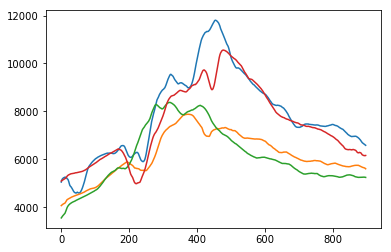

In [8]:
#look at individual plot
for row in data.index:
    plt.plot(data["Intensity_values"].loc[row])


In [11]:
data['Limits']=''
for row in data.index:
    img = data['Image'].loc[row]
    min1 = np.min(img)
    max1 = np.max(img)
    data['Limits'].loc[row] = [min1, max1]
limits = data['Limits'].values
limits = np.vstack(limits)
climits = [np.min(limits[:, 0]), np.max(limits[:,1])]
print(climits)

[0, 19703]


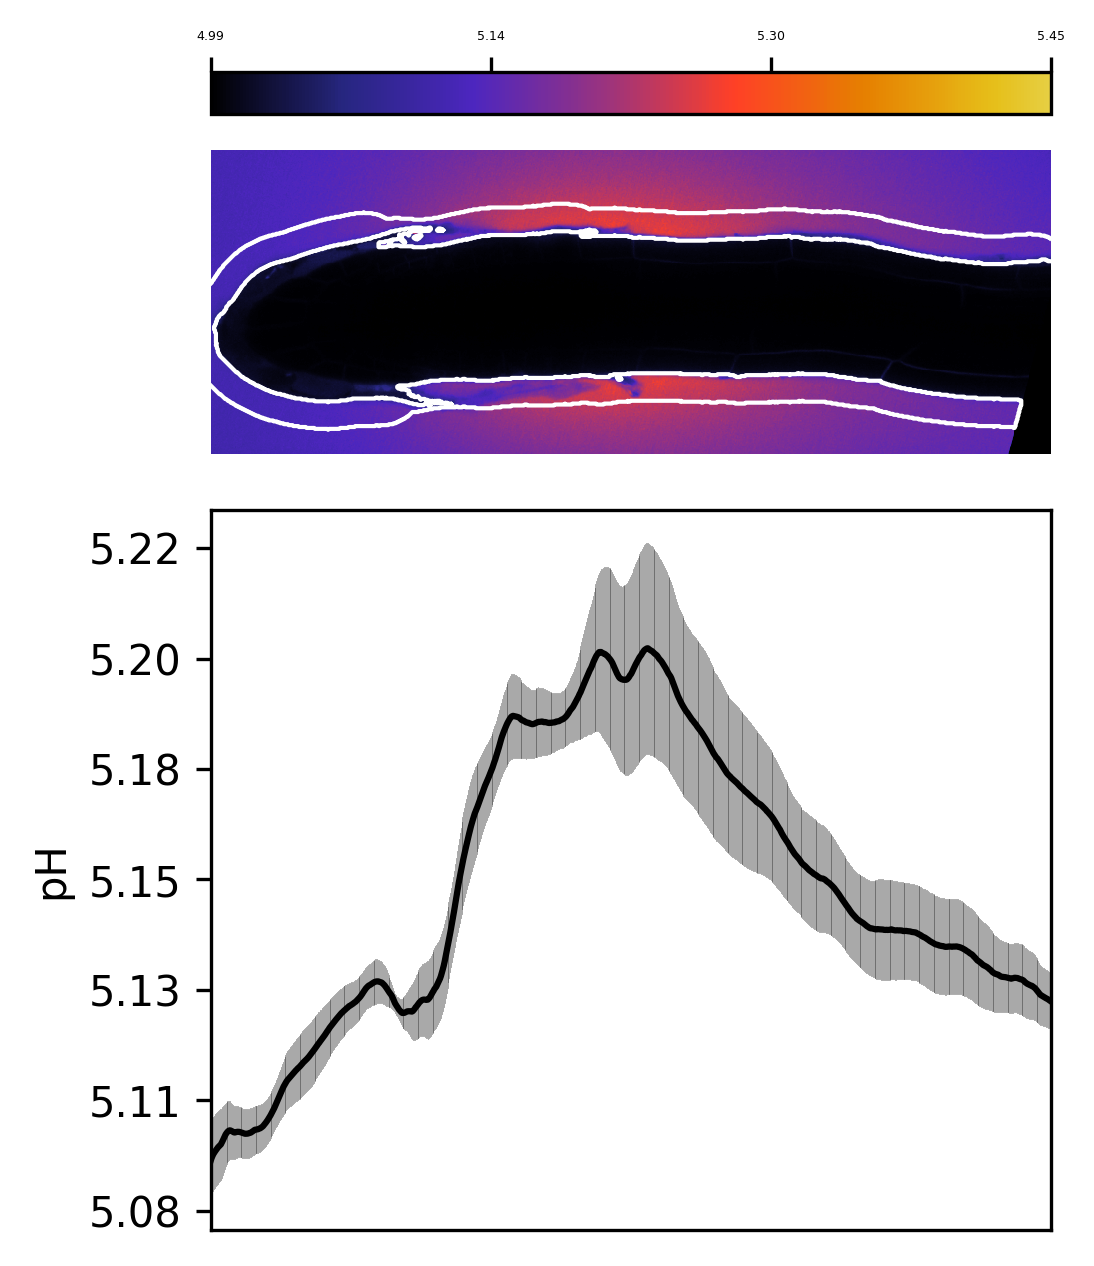

In [72]:
#plot summary figure
exampleImg = '7FITC488.tif'
fig1 = plt.figure( dpi=300, figsize=(4,6))
img = data['Image'].loc[exampleImg]
ax11 = fig1.add_axes([0.2, 0.4, 0.7, 0.4])
ax11.axis('off')
imgax1 = ax11.imshow(img)
imgax1.set_cmap(new_cmap)
clim1 = imgax1.get_clim()
ticks1 = np.linspace(clim1[0], clim1[1], 4)
cb = fig1.colorbar(imgax1, location = 'top', shrink =1, ticks = ticks1)#, shrink) #, orientation = 'horizental')
ax11.set_visible('off')
#replace tick marks on colorbar with pH
ticks1 = cb.ax.get_xticks()
ticks = cb.ax.get_xticklabels()
pHticks =[]
for i in ticks:
    pHticks.append("{0:.2f}".format((float(i.get_text()) - intercept)/slope))
#cb.set_ticks(ticks1.tolist())
cb.set_ticklabels(pHticks)
cb.ax.tick_params(labelsize = 3)

ax2 = fig1.add_axes([0.2, 0.12, 0.7, 0.4])
mean_data = np.vstack(data["Intensity_values"].values)
ax2.plot(np.mean(mean_data, axis=0), color ='k' )
import graphDB
graphDB.SEbarsToLinePlot(mean_data, 'k', ax2)
ax2.set_xlim([0, img.shape[1]])
ticks = ax2.get_yticks()
pHticks =[]
for i in ticks:
    pHticks.append("{0:.2f}".format((float(i) - intercept)/slope))
ax2.set_yticklabels(pHticks)
ax2.set_ylabel('pH')
ax2.get_xaxis().set_visible(False)

mask5 = np.zeros(img.flatten().shape, dtype = np.bool)
mask5 = mask5.flatten()
mask5[data['Mask'].loc[exampleImg]] = 1
mask5 = mask5.reshape(img.shape)
contours = skimage.measure.find_contours(mask5, 0.8)
for n, contour in enumerate(contours):
    ax11.plot(contour[:, 1], contour[:, 0], linewidth = 1, color = 'w')
savefile=os.path.join(outputfolder, row + '_summaryFigure.jpeg')
fig1.savefig(savefile)

In [73]:
def SEbarsToLinePlotY(data, color, axes):
    #data = np array ploted along axis=1
    for i in range(data.shape[1]):
        se = np.std(data[:, i]) / np.sqrt(data.shape[0])
        me = np.mean(data[:, i], axis=0)
        axes.plot([me-se, me+se],[i, i], alpha = 0.4, color = color, linewidth=0.2)

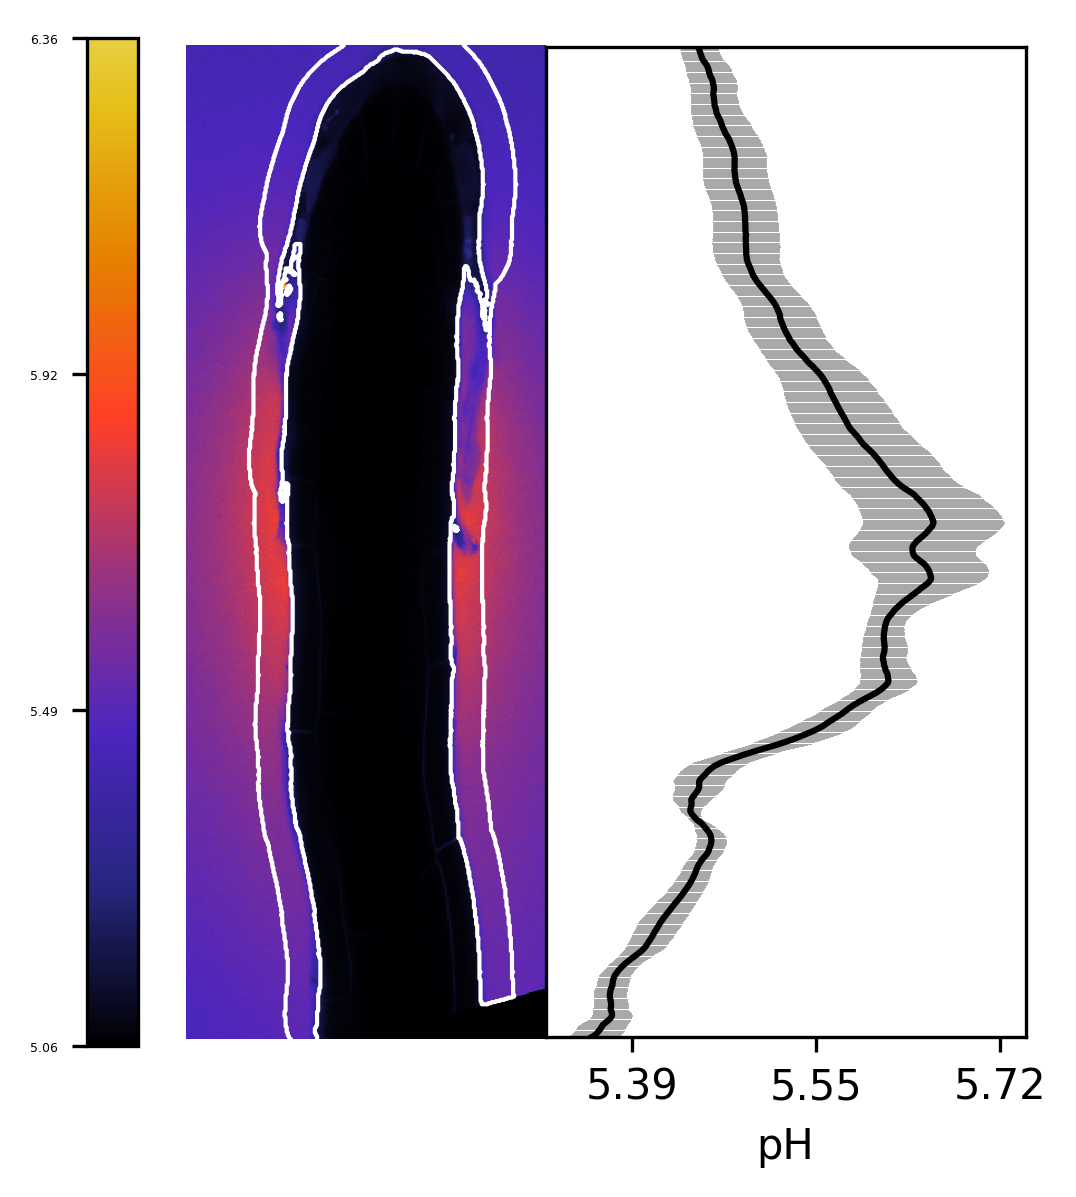

In [94]:
#plot summary figure
exampleImg = '7FITC488.tif'
fig1 = plt.figure( dpi=300, figsize=(4,6))
img = data['Image'].loc[exampleImg]
ax11 = fig1.add_axes([0.1, 0.1, 0.4, 0.8])
ax11.axis('off')
imgax1 = ax11.imshow(img.T)
imgax1.set_cmap(new_cmap)

clim1 = imgax1.get_clim()
ticks1 = np.linspace(clim1[0], clim1[1], 4)
cb = fig1.colorbar(imgax1, location = 'left', shrink =0.7, ticks = ticks1)#, shrink) #, orientation = 'horizental')
ax11.set_visible('off')
#replace tick marks on colorbar with pH
ticks1 = cb.ax.get_yticks()
ticks = cb.ax.get_yticklabels()
pHticks =[]
for i in ticks:
    pHticks.append("{0:.2f}".format((float(i.get_text()) - intercept)/slope))
#cb.set_ticks(ticks1.tolist())
cb.set_ticklabels(pHticks)
cb.ax.tick_params(labelsize = 3)


ax2 = fig1.add_axes([0.5, 0.225, 0.4, 0.55])
mean_data = np.vstack(data["Intensity_values"].values)
ax2.plot(np.mean(mean_data, axis=0),range(0, mean_data.shape[1]), color ='k' )

SEbarsToLinePlotY(mean_data, 'k', ax2)

ax2.set_ylim([0, img.shape[1]])
ax2.set_xlim((3822, 10346))
ticks = ax2.get_xticks()

pHticks =[]
for i in ticks:
    pHticks.append("{0:.2f}".format(((float(i)) - intercept)/slope))
ax2.set_xticklabels(pHticks)
ax2.set_xlabel('pH')
ax2.get_yaxis().set_visible(False)

mask5 = np.zeros(img.flatten().shape, dtype = np.bool)
mask5 = mask5.flatten()
mask5[data['Mask'].loc[exampleImg]] = 1
mask5 = mask5.reshape(img.shape)
contours = skimage.measure.find_contours(mask5.T, 0.8)
for n, contour in enumerate(contours):
    ax11.plot(contour[:, 1], contour[:, 0], linewidth = 1, color = 'w')
savefile=os.path.join(outputfolder, row + '_summaryFigure.tif')
fig1.savefig(savefile)
